In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm # norm : A normal continuous random variable.
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore")

# Defining the working directories
input_path1 = './data/house-prices-advanced-regression-techniques/'
input_path2 = './data/ames-housing-dataset/'

In [19]:
house_data = pd.read_csv(input_path2 + 'AmesHousing.csv')
test = pd.read_csv(input_path1 + 'test.csv')
data_w = house_data.copy()
data_w.columns = data_w.columns.str.replace(' ', '') # Replacing the white spaces in columns' names
data_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order          2930 non-null   int64  
 1   PID            2930 non-null   int64  
 2   MSSubClass     2930 non-null   int64  
 3   MSZoning       2930 non-null   object 
 4   LotFrontage    2440 non-null   float64
 5   LotArea        2930 non-null   int64  
 6   Street         2930 non-null   object 
 7   Alley          198 non-null    object 
 8   LotShape       2930 non-null   object 
 9   LandContour    2930 non-null   object 
 10  Utilities      2930 non-null   object 
 11  LotConfig      2930 non-null   object 
 12  LandSlope      2930 non-null   object 
 13  Neighborhood   2930 non-null   object 
 14  Condition1     2930 non-null   object 
 15  Condition2     2930 non-null   object 
 16  BldgType       2930 non-null   object 
 17  HouseStyle     2930 non-null   object 
 18  OverallQ

In [ ]:
data_w.head()

### EDA & VISUALIZATION
Before working with any kind of data it is important to understand theml. A crutial step to this aim is the Exploratory data analysis (EDA): a combination of visualizations and statistical analysis (uni, bi, and multivariate) that helps us to better understand the data we are working with and to gain insight into their relationships. So let's explore our target variable and how the other features influence it.

0       215000
1       105000
2       172000
3       244000
4       189900
         ...  
2925    142500
2926    131000
2927    132000
2928    170000
2929    188000
Name: SalePrice, Length: 2930, dtype: int64 180796.0600682594 79873.05865192253


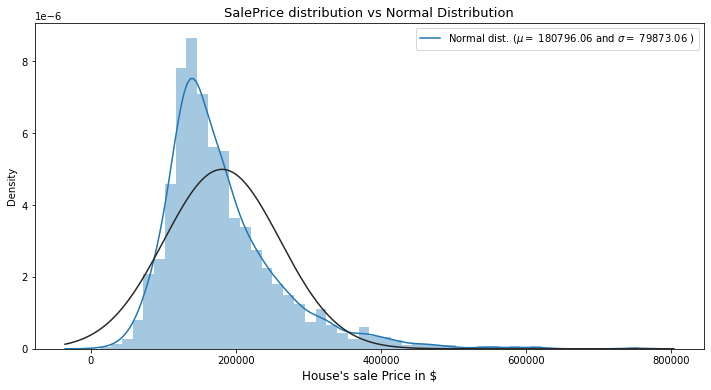

In [8]:
(mu, sigma) = norm.fit(data_w['SalePrice']) # what is mu, sigma
print(data_w['SalePrice'], mu, sigma)

plt.figure(figsize = (12, 6))
sns.distplot(data_w['SalePrice'], kde = True, hist=True, fit = norm)
plt.title('SalePrice distribution vs Normal Distribution', fontsize = 13)
plt.xlabel("House's sale Price in $", fontsize = 12)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.show()

In literature, acceptable values for skewness are between -0.5 ~ 05 whire -2 and 2 for kurtosis. 

In [10]:
from scipy import stats

shap_t, shap_p = stats.shapiro(data_w['SalePrice'])

print("Skewness: %f" % abs(data_w['SalePrice']).skew())
print("Kurtosis: %f" % abs(data_w['SalePrice']).kurt())
print("Shapiro_Test: %f" % shap_t)
print("Shapiro_Test: %f" % shap_p)

Skewness: 1.743500
Kurtosis: 5.118900
Shapiro_Test: 0.876261
Shapiro_Test: 0.000000


corellation

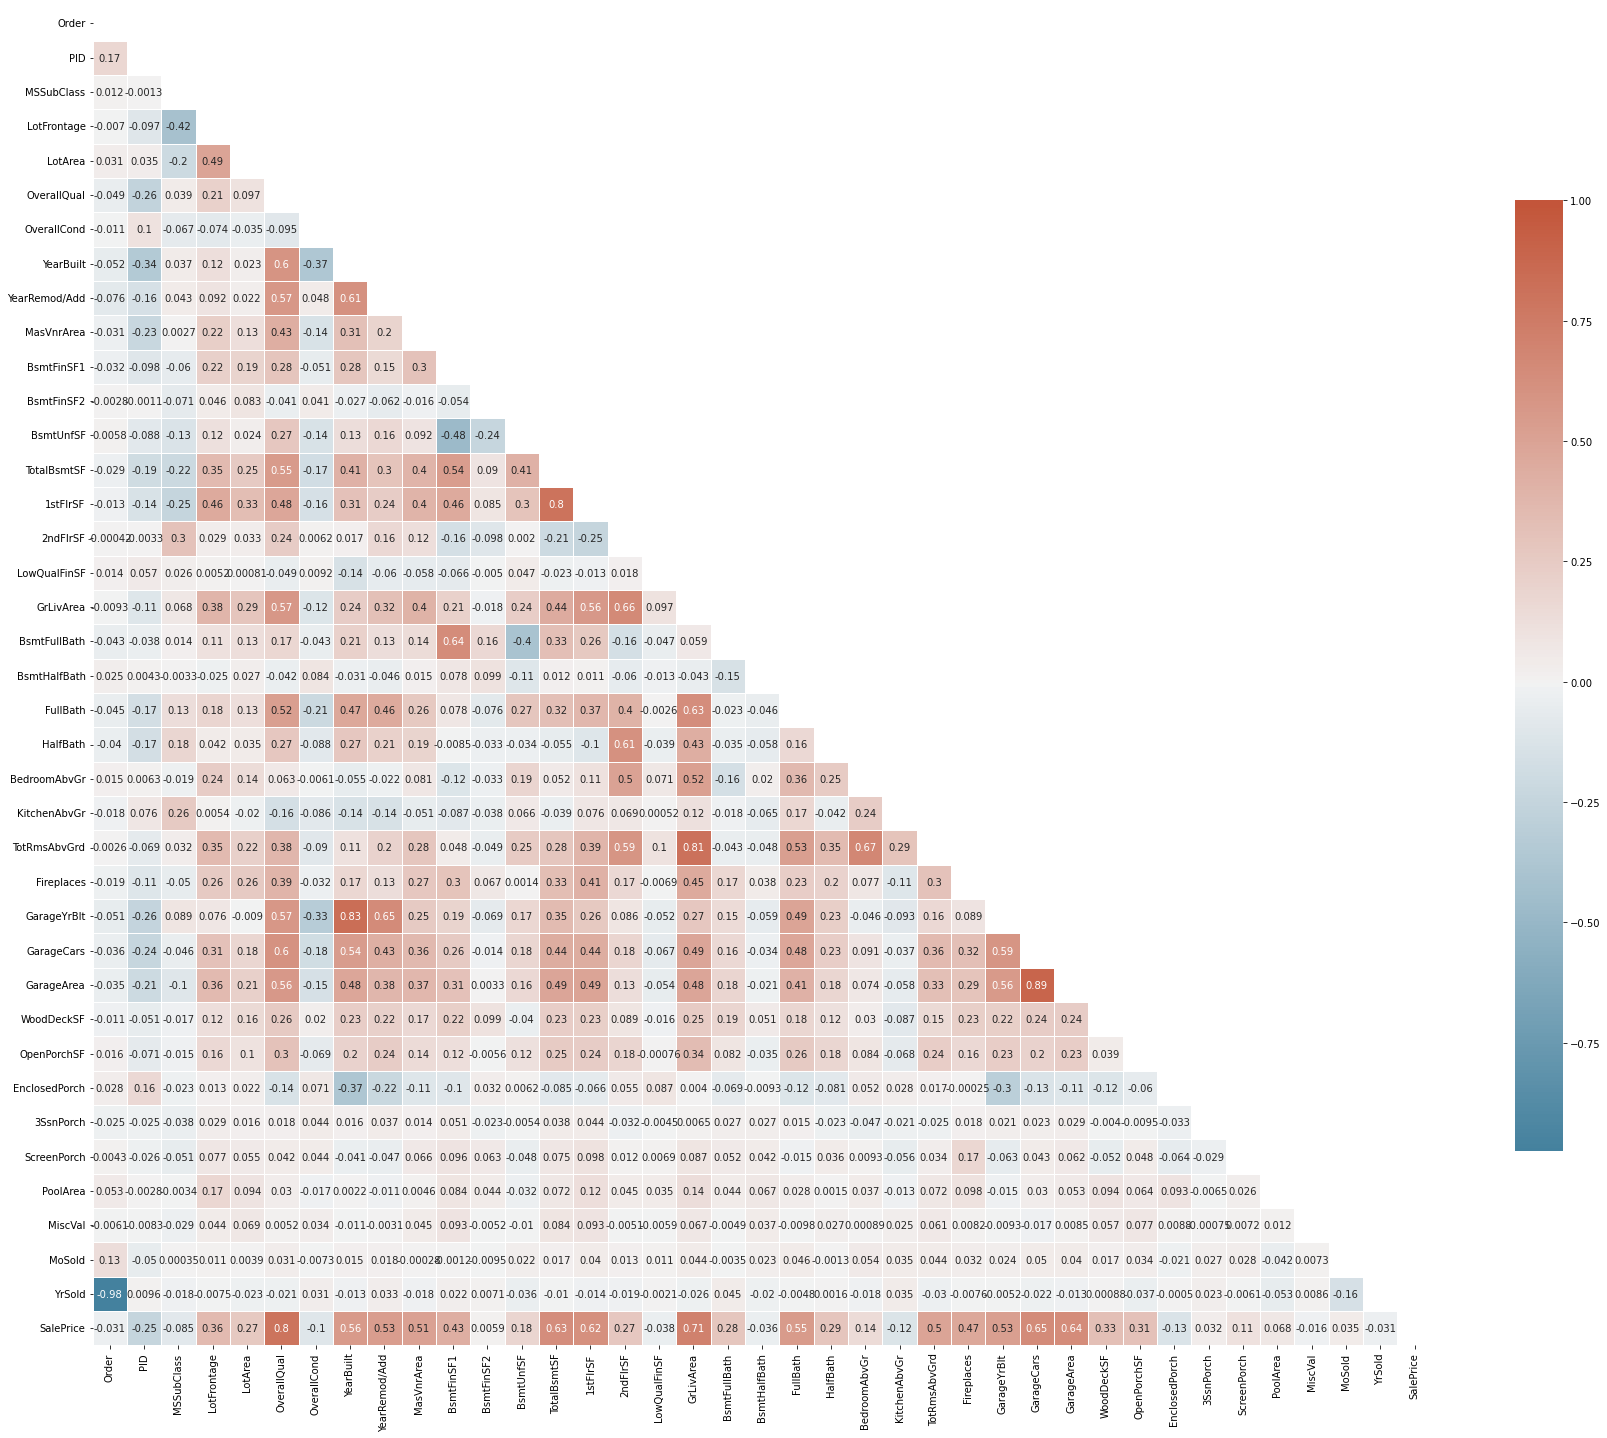

In [12]:
f, ax = plt.subplots(figsize=(30,35))
mat = data_w.corr('pearson')
mask=np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

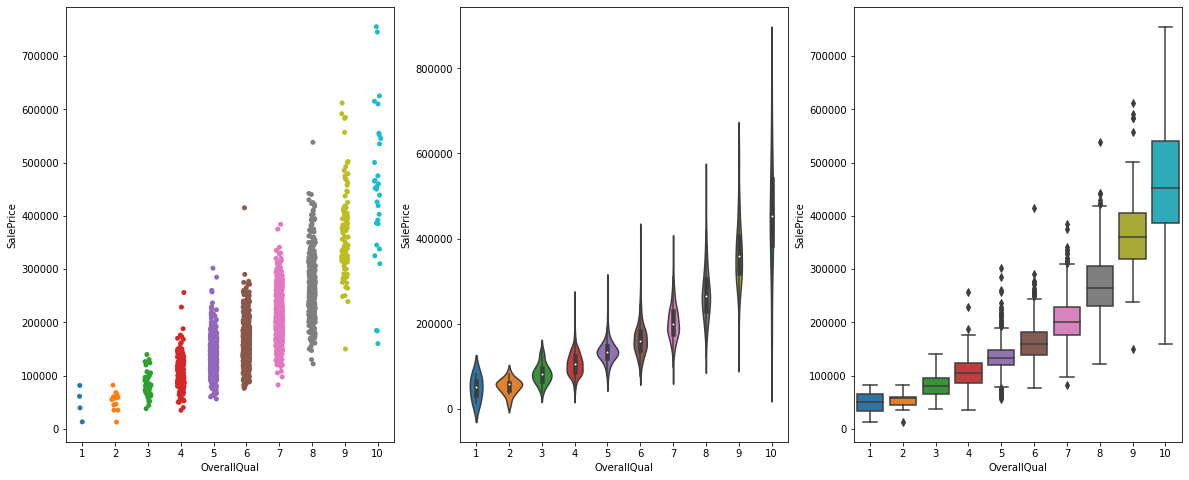

In [13]:
# OverallQuall - SalePrice [Person = 0.8]

figure, ax = plt.subplots(1,3, figsize = (20,8))
sns.stripplot(data=data_w, x = 'OverallQual', y='SalePrice', ax = ax[0])
sns.violinplot(data=data_w, x = 'OverallQual', y='SalePrice', ax = ax[1])
sns.boxplot(data=data_w, x = 'OverallQual', y='SalePrice', ax = ax[2])
plt.show()

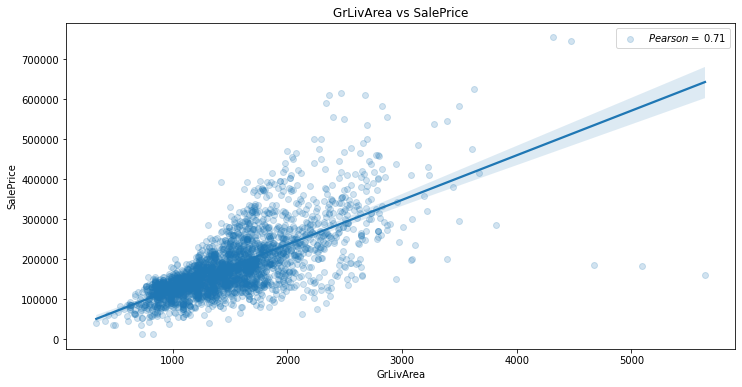

In [14]:
# GrLivArea vs SalePrice [corr = 0.71]

Pearson_GrLiv = 0.71
plt.figure(figsize = (12,6))
sns.regplot(data=data_w, x = 'GrLivArea', y='SalePrice', scatter_kws={'alpha':0.2})
plt.title('GrLivArea vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_GrLiv)], loc = 'best')
plt.show()

### DATA PROCESSING
- Looking at potential NaN
- Dealing with categorical feature (e.g. Dummy coding)
- Normalization

N.B

In [20]:
# Separating Target and Features

target = data_w['SalePrice']
test_id = test['Id']
test = test.drop(['Id'], axis = 1)
data_w2 = data_w.drop(['SalePrice', 'Order', 'PID'], axis=1)

# concat
train_test = pd.concat([data_w2, test], axis=0, sort=False)

In [15]:
test

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0     1461          20       RH         80.0    11622   Pave   NaN      Reg   
1     1462          20       RL         81.0    14267   Pave   NaN      IR1   
2     1463          60       RL         74.0    13830   Pave   NaN      IR1   
3     1464          60       RL         78.0     9978   Pave   NaN      IR1   
4     1465         120       RL         43.0     5005   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1454  2915         160       RM         21.0     1936   Pave   NaN      Reg   
1455  2916         160       RM         21.0     1894   Pave   NaN      Reg   
1456  2917          20       RL        160.0    20000   Pave   NaN      Reg   
1457  2918          85       RL         62.0    10441   Pave   NaN      Reg   
1458  2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence  \
0            Lvl    AllPub  ...         120        0    NaN  MnPrv   
1            Lvl    AllPub  ...           0        0    NaN    NaN   
2            Lvl    AllPub  ...           0        0    NaN  MnPrv   
3            Lvl    AllPub  ...           0        0    NaN    NaN   
4            HLS    AllPub  ...         144        0    NaN    NaN   
...          ...       ...  ...         ...      ...    ...    ...   
1454         Lvl    AllPub  ...           0        0    NaN    NaN   
1455         Lvl    AllPub  ...           0        0    NaN    NaN   
1456         Lvl    AllPub  ...           0        0    NaN    NaN   
1457         Lvl    AllPub  ...           0        0    NaN  MnPrv   
1458         Lvl    AllPub  ...           0        0    NaN    NaN   

     MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  
0            NaN       0      6    2010        WD         Normal  
1           Gar2   12500      6    2010        WD         Normal  
2            NaN       0      3    2010        WD         Normal  
3            NaN       0      6    2010        WD         Normal  
4            NaN       0      1    2010        WD         Normal  
...          ...     ...    ...     ...       ...            ...  
1454         NaN       0      6    2006        WD         Normal  
1455         NaN       0      4    2006        WD        Abnorml  
1456         NaN       0      9    2006        WD        Abnorml  
1457        Shed     700      7    2006        WD         Normal  
1458         NaN       0     11    2006        WD         Normal  

[1459 rows x 80 columns]

In [24]:
# find nan

nan = pd.DataFrame(train_test.isna().sum(), columns = ['NaN_sum'])
nan['feat'] = nan.index
nan['Perc(%)'] = (nan['NaN_sum']/1460)*100
nan = nan[nan['NaN_sum'] > 0]
nan = nan.sort_values(by = ['NaN_sum'])
nan['Usability'] = np.where(nan['Perc(%)'] > 20, 'Discard', 'Keep')
nan

NaN_sum           feat     Perc(%) Usability
Exterior1st          1    Exterior1st    0.068493      Keep
Exterior2nd          1    Exterior2nd    0.068493      Keep
KitchenQual          1    KitchenQual    0.068493      Keep
Electrical           1     Electrical    0.068493      Keep
SaleType             1       SaleType    0.068493      Keep
TotalBsmtSF          2    TotalBsmtSF    0.136986      Keep
GarageArea           2     GarageArea    0.136986      Keep
GarageCars           2     GarageCars    0.136986      Keep
Utilities            2      Utilities    0.136986      Keep
Functional           2     Functional    0.136986      Keep
BsmtUnfSF            2      BsmtUnfSF    0.136986      Keep
BsmtFinSF1           2     BsmtFinSF1    0.136986      Keep
BsmtFinSF2           2     BsmtFinSF2    0.136986      Keep
BsmtHalfBath         4   BsmtHalfBath    0.273973      Keep
BsmtFullBath         4   BsmtFullBath    0.273973      Keep
MSZoning             4       MSZoning    0.273973      Keep
MasVnrArea          38     MasVnrArea    2.602740      Keep
MasVnrType          39     MasVnrType    2.671233      Keep
BsmtFinType1       122   BsmtFinType1    8.356164      Keep
BsmtFinType2       123   BsmtFinType2    8.424658      Keep
BsmtQual           124       BsmtQual    8.493151      Keep
BsmtCond           125       BsmtCond    8.561644      Keep
BsmtExposure       127   BsmtExposure    8.698630      Keep
GarageType         233     GarageType   15.958904      Keep
GarageCond         237     GarageCond   16.232877      Keep
GarageQual         237     GarageQual   16.232877      Keep
GarageYrBlt        237    GarageYrBlt   16.232877      Keep
GarageFinish       237   GarageFinish   16.232877      Keep
LotFrontage        717    LotFrontage   49.109589   Discard
YearRemod/Add     1459  YearRemod/Add   99.931507   Discard
FireplaceQu       2152    FireplaceQu  147.397260   Discard
YearRemodAdd      2930   YearRemodAdd  200.684932   Discard
Fence             3527          Fence  241.575342   Discard
Alley             4084          Alley  279.726027   Discard
MiscFeature       4232    MiscFeature  289.863014   Discard
PoolQC            4373         PoolQC  299.520548   Discard

In [22]:
nan = pd.DataFrame(train_test.isna().sum(), columns = ['NaN_sum'])
nan

NaN_sum
MSSubClass           0
MSZoning             4
LotFrontage        717
LotArea              0
Street               0
...                ...
MoSold               0
YrSold               0
SaleType             1
SaleCondition        0
YearRemodAdd      2930

[80 rows x 1 columns]

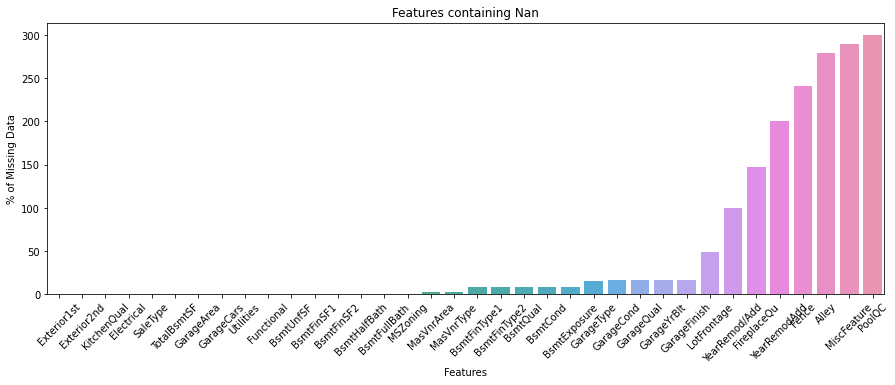

In [25]:
# Plotting Nan

plt.figure(figsize = (15,5))
sns.barplot(x = nan['feat'], y = nan['Perc(%)'])
plt.xticks(rotation=45)
plt.title('Features containing Nan')
plt.xlabel('Features')
plt.ylabel('% of Missing Data')
plt.show()

In [28]:
# Converting on-numeric predictitors stored as numbers into string

train_test['MSSubClass'] = train_test['MSSubClass'].apply(str)
train_test['YrSold'] = train_test['YrSold'].apply(str)
train_test['MoSold'] = train_test['MoSold'].apply(str)

# Filtering Categorial NaN (That we know how to fill due to the description file
train_test['Functional'] = train_test['Functional'].fillna('Typ')
train_test['Electrical'] = train_test['Electrical'].fillna("SBrkr")
train_test['KitchenQual'] = train_test['KitchenQual'].fillna("TA")
train_test['Exterior1st'] = train_test['Exterior1st'].fillna(train_test['Exterior1st'].mode()[0])
train_test['Exterior2nd'] = train_test['Exterior2nd'].fillna(train_test['Exterior2nd'].mode()[0])
train_test['SaleType'] = train_test['SaleType'].fillna(train_test['SaleType'].mode()[0])
train_test["PoolQC"] = train_test["PoolQC"].fillna("None")
train_test["Alley"] = train_test["Alley"].fillna("None")
train_test['FireplaceQu'] = train_test['FireplaceQu'].fillna("None")
train_test['Fence'] = train_test['Fence'].fillna("None")
train_test['MiscFeature'] = train_test['MiscFeature'].fillna("None")

for col in ('GarageArea', 'GarageCars'):
    train_test[col] = train_test[col].fillna(0)
        
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train_test[col] = train_test[col].fillna('None')
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train_test[col] = train_test[col].fillna('None')
    
for col in train_test:
    if train_test[col].isna().sum() > 0:
        print(train_test[col][0])


0    RL
0    RH
Name: MSZoning, dtype: object
0    141.0
0     80.0
Name: LotFrontage, dtype: float64
0    AllPub
0    AllPub
Name: Utilities, dtype: object
0    1960.0
0       NaN
Name: YearRemod/Add, dtype: float64
0    Stone
0     None
Name: MasVnrType, dtype: object
0    112.0
0      0.0
Name: MasVnrArea, dtype: float64
0    639.0
0    468.0
Name: BsmtFinSF1, dtype: float64
0      0.0
0    144.0
Name: BsmtFinSF2, dtype: float64
0    441.0
0    270.0
Name: BsmtUnfSF, dtype: float64
0    1080.0
0     882.0
Name: TotalBsmtSF, dtype: float64
0    1.0
0    0.0
Name: BsmtFullBath, dtype: float64
0    0.0
0    0.0
Name: BsmtHalfBath, dtype: float64
0    1960.0
0    1961.0
Name: GarageYrBlt, dtype: float64
0       NaN
0    1961.0
Name: YearRemodAdd, dtype: float64


In [ ]:
# Removing the useless variables

useless = ['GarageYrBlt', 'YearRemodAdd']
train_test = train_test.drop(useless, axis = 1)

# Imputing with KnnREgressor (we can also use different Imputers)
def impute_knn(df):
    ttn = train_test.select_dtypes(include=[np.number])
    ttc = train_test.select_dtypes(exclude=[np.number])
    
    cols_nan = ttn.columns[ttn.isna().any()].tolist()
    cols_no_nan = ttn.columns.difference(cols_nan).values
    
    for col in cols_nan:
        imp_test = ttn[ttn[col].isna()]
        imp_train = ttn.dropna()
        model = KNeighborsREgressor(n_neighbors=5)
        knr = model.fit(imp_train[cols_no_nan], imp_train[col])
        ttn.loc[ttn[col].isna(), col] = knr.predict(imp_test[cols_no_nan])
    
    return pd.concat([ttn, ttc], axis = 1)

train_test = impute_knn(train_test)

objects = []

for i in train_test.colums:
    if train_test[i].dtype == object:
        objects.append(i)
train_test.update(train_test[objects].fillna('None'))

# Checking NaN Presence

for col in train_Test:
    if train_test[col].isna().sum() > 0:
        print(train_test[col][0])

Feature Engineering

In [37]:
train_test["SqFtPerRoom"] = train_test["GrLivArea"] / (train_test["TotRmsAbvGrd"] +
                                                       train_test["FullBath"] +
                                                       train_test["HalfBath"] +
                                                       train_test["KitchenAbvGr"])

train_test['Total_Home_Quality'] = train_test['OverallQual'] + train_test['OverallCond']

train_test['Total_Bathrooms'] = (train_test['FullBath'] + (0.5 * train_test['HalfBath']) +
                               train_test['BsmtFullBath'] + (0.5 * train_test['BsmtHalfBath']))

train_test["HighQualSF"] = train_test["1stFlrSF"] + train_test["2ndFlrSF"]

# Converting non-numeric predictors stored as numbers into string

train_test['MSSubClass'] = train_test['MSSubClass'].apply(str)
train_test['YrSold'] = train_test['YrSold'].apply(str)
train_test['MoSold'] = train_test['MoSold'].apply(str)

# Creating dummy variables from categorical features

train_test_dummy = pd.get_dummies(train_test)

# Fetch all numeric features

numeric_features = train_test_dummy.dtypes[train_test_dummy.dtypes != object].index
skewed_features = train_test_dummy[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[skewed_features > 0.5]
skew_index = high_skew.index

# Normalize skewed features using log_transformation

for i in skew_index:
    train_test_dummy[i] = np.log1p(train_test_dummy[i])

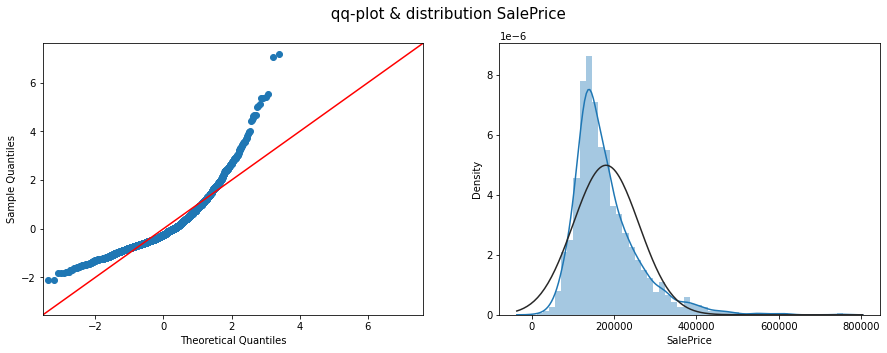

In [38]:
# SalePrice before transformation

fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle(" qq-plot & distribution SalePrice ", fontsize= 15)

sm.qqplot(target, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])

sns.distplot(target, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

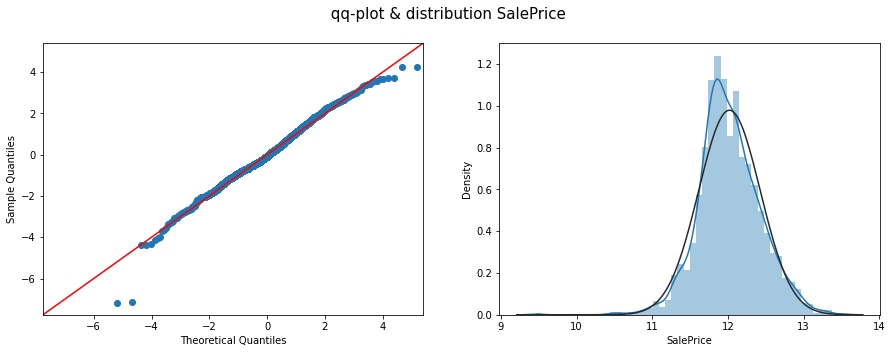

In [39]:
# SalePrice after transformation

target_log = np.log1p(target)

fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle(" qq-plot & distribution SalePrice ", fontsize= 15)

sm.qqplot(target_log, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])

sns.distplot(target_log, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

# Modeling

In [45]:
import shap
import xgboost as xgb
from catboost import Pool
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

In [55]:
train = train_test_dummy[0:2930]
test = train_test_dummy[2930:]
test['Id'] = test_id # 왜 ID를 다시 넣어주지?

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, train, target_log, scoring="neg_mean_squared_error", cv=kf)) # kf 변수를
    return (rmse) 

In [47]:
# 10 Fold Cross validation

kf = KFold(n_splits=10, random_state=42, shuffle=True)

cv_scores = []
cv_std = []

baseline_models = ['Linear_Reg.','Bayesian_Ridge_Reg.','LGBM_Reg.','SVR',
                   'Dec_Tree_Reg.','Random_Forest_Reg.', 'XGB_Reg.',
                   'Grad_Boost_Reg.','Cat_Boost_Reg.','Stacked_Reg.']

# Linear Regression

lreg = LinearRegression()
score_lreg = cv_rmse(lreg)
cv_scores.append(score_lreg.mean())
cv_std.append(score_lreg.std())

# Bayesian Ridge Regression

brr = BayesianRidge(compute_score=True)
score_brr = cv_rmse(brr)
cv_scores.append(score_brr.mean())
cv_std.append(score_brr.std())

# Light Gradient Boost Regressor

l_gbm = LGBMRegressor(objective='regression')
score_l_gbm = cv_rmse(l_gbm)
cv_scores.append(score_l_gbm.mean())
cv_std.append(score_l_gbm.std())

# Support Vector Regression

svr = SVR()
score_svr = cv_rmse(svr)
cv_scores.append(score_svr.mean())
cv_std.append(score_svr.std())

# Decision Tree Regressor

dtr = DecisionTreeRegressor()
score_dtr = cv_rmse(dtr)
cv_scores.append(score_dtr.mean())
cv_std.append(score_dtr.std())

# Random Forest Regressor

rfr = RandomForestRegressor()
score_rfr = cv_rmse(rfr)
cv_scores.append(score_rfr.mean())
cv_std.append(score_rfr.std())

# XGB Regressor

xgb = xgb.XGBRegressor()
score_xgb = cv_rmse(xgb)
cv_scores.append(score_xgb.mean())
cv_std.append(score_xgb.std())

# Gradient Boost Regressor

gbr = GradientBoostingRegressor()
score_gbr = cv_rmse(gbr)
cv_scores.append(score_gbr.mean())
cv_std.append(score_gbr.std())

# Cat Boost Regressor

catb = CatBoostRegressor()
score_catb = cv_rmse(catb)
cv_scores.append(score_catb.mean())
cv_std.append(score_catb.std())

# Stacked Regressor

stack_gen = StackingRegressor(regressors=(CatBoostRegressor(),
                                          LinearRegression(),
                                          BayesianRidge(),
                                          GradientBoostingRegressor()),
                              meta_regressor = CatBoostRegressor(),
                              use_features_in_secondary = True)

score_stack_gen = cv_rmse(stack_gen)
cv_scores.append(score_stack_gen.mean())
cv_std.append(score_stack_gen.std())

final_cv_score = pd.DataFrame(baseline_models, columns = ['Regressors'])
final_cv_score['RMSE_mean'] = cv_scores
final_cv_score['RMSE_std'] = cv_std

Learning rate set to 0.047722
0:	learn: 0.3914491	total: 2.11ms	remaining: 2.11s
1:	learn: 0.3791001	total: 4.3ms	remaining: 2.14s
2:	learn: 0.3671345	total: 6.29ms	remaining: 2.09s
3:	learn: 0.3553497	total: 8.2ms	remaining: 2.04s
4:	learn: 0.3448796	total: 10.4ms	remaining: 2.07s
5:	learn: 0.3345069	total: 12.3ms	remaining: 2.04s
6:	learn: 0.3248577	total: 14.2ms	remaining: 2.01s
7:	learn: 0.3152957	total: 16.2ms	remaining: 2.01s
8:	learn: 0.3060791	total: 18.5ms	remaining: 2.04s
9:	learn: 0.2971368	total: 21.2ms	remaining: 2.1s
10:	learn: 0.2898411	total: 23.7ms	remaining: 2.13s
11:	learn: 0.2827554	total: 25.6ms	remaining: 2.11s
12:	learn: 0.2751836	total: 27.7ms	remaining: 2.11s
13:	learn: 0.2683907	total: 30.5ms	remaining: 2.15s
14:	learn: 0.2616446	total: 32.8ms	remaining: 2.16s
15:	learn: 0.2551598	total: 35.2ms	remaining: 2.17s
16:	learn: 0.2488429	total: 37.3ms	remaining: 2.16s
17:	learn: 0.2426491	total: 39.7ms	remaining: 2.17s
18:	learn: 0.2372491	total: 42.1ms	remaining: 2

In [48]:
final_cv_score

Regressors  RMSE_mean  RMSE_std
0          Linear_Reg.        NaN       NaN
1  Bayesian_Ridge_Reg.        NaN       NaN
2            LGBM_Reg.   0.123671  0.012836
3                  SVR        NaN       NaN
4        Dec_Tree_Reg.        NaN       NaN
5   Random_Forest_Reg.        NaN       NaN
6             XGB_Reg.   0.130708  0.008516
7      Grad_Boost_Reg.        NaN       NaN
8       Cat_Boost_Reg.   0.112631  0.016028
9         Stacked_Reg.        NaN       NaN

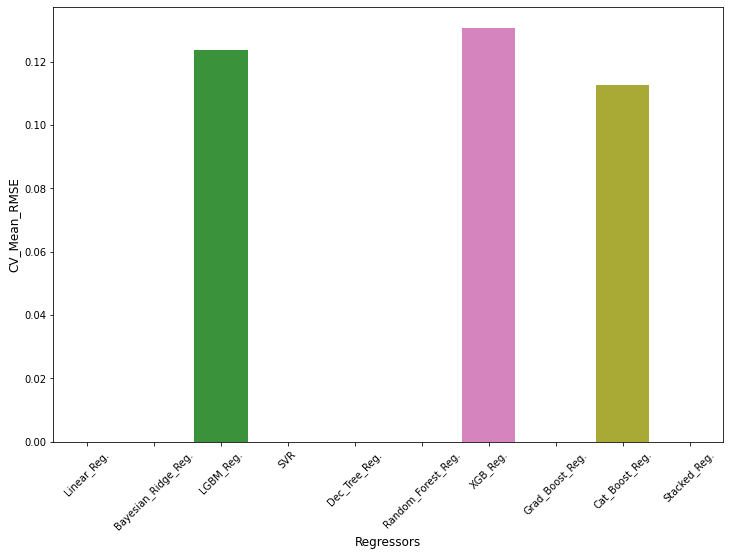

In [49]:
plt.figure(figsize = (12,8))
sns.barplot(final_cv_score['Regressors'], final_cv_score['RMSE_mean'])
plt.xlabel('Regressors', fontsize=12)
plt.ylabel('CV_Mean_RMSE', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [53]:
# Train-Test split the data

X_train,X_val,y_train,y_val = train_test_split(train,target_log,test_size = 0.1,random_state=42)

# Cat Boost Regressor

cat = CatBoostRegressor()
cat_model = cat.fit(X_train,y_train,
                     eval_set = (X_val,y_val),
                     plot=True,
                     verbose = 0)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [56]:
cat_pred = cat_model.predict(X_val)
cat_score = rmse(y_val, cat_pred)
cat_score

0.09295125368831354

In [57]:
# Features' importance of our model

feat_imp = cat_model.get_feature_importance(prettified=True)
feat_imp

Feature Id  Importances
0           OverallQual    15.605991
1            HighQualSF     9.343992
2    Total_Home_Quality     6.348965
3       Total_Bathrooms     5.060434
4           TotalBsmtSF     4.782829
..                  ...          ...
349    MiscFeature_None     0.000000
350    MiscFeature_TenC     0.000000
351            MoSold_5     0.000000
352        SaleType_CWD     0.000000
353         SaleType_WD     0.000000

[354 rows x 2 columns]

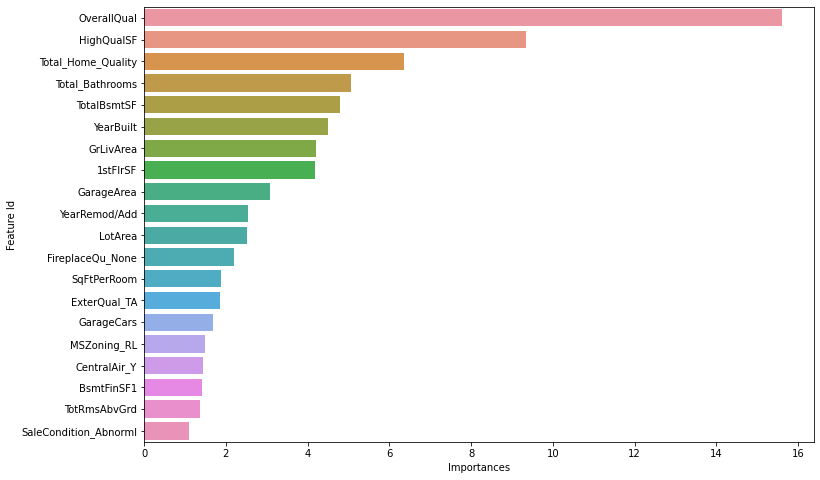

In [58]:
# Plotting top 20 features importance

plt.figure(figsize = (12,8))
sns.barplot(feat_imp['Importances'][:20],feat_imp['Feature Id'][:20], orient = 'h')
plt.show()

In [59]:
# Feature importance Interactive Plot 

train_pool = Pool(X_train)
val_pool = Pool(X_val)

explainer = shap.TreeExplainer(cat_model) # insert your model
shap_values = explainer.shap_values(train_pool) # insert your train Pool object

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:200,:], X_train.iloc[:200,:])

# The plot represents just a slice of the Training data (200 observations)

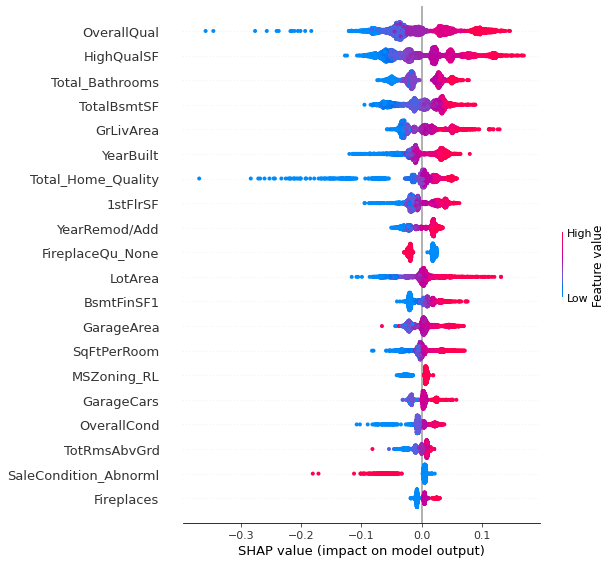

In [61]:
shap.summary_plot(shap_values, X_train)

In [64]:
# Features's Interactions

train_data = Pool(X_train)
interaction = cat_model.get_feature_importance(train_data, type="Interaction")
column_names = X_train.columns.values
interaction = pd.DataFrame(interaction, columns=["feature1", "feature2", "importance"])
interaction.feature1 = interaction.feature1.apply(lambda l: column_names[int(l)])
interaction.feature2 = interaction.feature2.apply(lambda l: column_names[int(l)])
interaction.head(20)

feature1               feature2  importance
0          OverallQual             HighQualSF    0.489962
1          OverallQual             GarageArea    0.470099
2          OverallQual            TotalBsmtSF    0.460525
3          OverallQual     Total_Home_Quality    0.369243
4          TotalBsmtSF              GrLivArea    0.343249
5          TotalBsmtSF             GarageArea    0.342958
6             1stFlrSF             HighQualSF    0.333621
7              LotArea            OverallQual    0.331250
8   Total_Home_Quality             HighQualSF    0.326094
9          OverallQual        Total_Bathrooms    0.307941
10           BsmtUnfSF             GarageArea    0.301847
11          BsmtFinSF1             HighQualSF    0.294156
12             LotArea             HighQualSF    0.289302
13           YearBuilt              GrLivArea    0.281656
14           GrLivArea     Total_Home_Quality    0.279287
15         OverallQual              GrLivArea    0.264578
16             LotArea            GarageYrBlt    0.256061
17         OverallQual  SaleCondition_Abnorml    0.253880
18             LotArea             GarageArea    0.244696
19          GarageArea     Total_Home_Quality    0.242337

In [65]:
cat_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.05929400026798248,
 'score_function': 'Cosine',
 'task_type':

Hyperparameter Optimization

In [ ]:
grid = {
    'iterations': [1000, 6000],
    'learning_rate': [0.05, 0.005, 0.0005],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 9]
}

final_model = CatBoostRegressor()
randomized_search_result = final_model.randomized_search(grid, X = X_train, y=y_train, verbose = False, plot = True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 12.0164474	test: 12.0164015	best: 12.0164015 (0)	total: 2.25ms	remaining: 2.24s
1:	learn: 12.0104596	test: 12.0104071	best: 12.0104071 (1)	total: 3.91ms	remaining: 1.95s
2:	learn: 12.0044752	test: 12.0044201	best: 12.0044201 (2)	total: 5.04ms	remaining: 1.67s
3:	learn: 11.9985030	test: 11.9984674	best: 11.9984674 (3)	total: 6.16ms	remaining: 1.53s
4:	learn: 11.9925349	test: 11.9924938	best: 11.9924938 (4)	total: 7.09ms	remaining: 1.41s
5:	learn: 11.9865633	test: 11.9865250	best: 11.9865250 (5)	total: 8.18ms	remaining: 1.35s
6:	learn: 11.9805890	test: 11.9805486	best: 11.9805486 (6)	total: 9.45ms	remaining: 1.34s
7:	learn: 11.9746215	test: 11.9745790	best: 11.9745790 (7)	total: 10.6ms	remaining: 1.31s
8:	learn: 11.9686572	test: 11.9686149	best: 11.9686149 (8)	total: 11.7ms	remaining: 1.29s
9:	learn: 11.9627093	test: 11.9626664	best: 11.9626664 (9)	total: 13.1ms	remaining: 1.29s
10:	learn: 11.9567675	test: 11.9567403	best: 11.9567403 (10)	total: 15.7ms	remaining: 1.41s
11:	lear